In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

from keras.callbacks import TensorBoard

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Embeddings

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

37658

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 35 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE       ': 4,
 'D.G. ORGANIZZAZIONE                                   ': 5,
 'D.G. ORGANIZZAZIONE E RISORSE                         ': 6,
 'D.G. POLITICHE TERRITORIALI, AMBIENTALI E PER LA MOBIL': 7,
 'D.G. PRESIDENZA                                       ': 8,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 9,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 10,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 11,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 12,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 13,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 14,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 15,
 'DIPARTIMENTO SVILUPPO ECONOMICO           

## Data Preparation

We need to create the function that transform the x and y.
In this case we need to:
- x: pad the sequences
- y: one hot encoding

In [4]:
maxlen = max([len(x) for x in x_train])
maxlen

166

In [5]:
from functools import partial

def x_transformer(x_data):
    return partial(tf.keras.preprocessing.sequence.pad_sequences, x_data, maxlen)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [6]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 35
training size 114940, validation size 28735


In [7]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## The Effects of Word Embeddings

Before using a word embedding as a layer in our network let evaluate the effect of embeddings by training a simple classifier that has it as only layer.

In [8]:
def build_embed_model(num_words, num_classes, embed_size):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
embed_model = build_embed_model(num_words, num_classes, 100)
embed_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                581035    
Total params: 4,346,835
Trainable params: 4,346,835
Non-trainable params: 0
_________________________________________________________________


In [10]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('only_embedding', '64')),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

In [11]:
embed_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=20, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/20
898/898 [==============================] - 22s 25ms/step - loss: 8.7697 - acc: 0.2196 - val_loss: 8.4020 - val_acc: 0.3207
Epoch 2/20
898/898 [==============================] - 22s 24ms/step - loss: 8.2379 - acc: 0.3735 - val_loss: 8.2085 - val_acc: 0.3854
Epoch 3/20
898/898 [==============================] - 23s 25ms/step - loss: 7.4900 - acc: 0.4449 - val_loss: 7.1568 - val_acc: 0.4371
Epoch 4/20
898/898 [==============================] - 22s 25ms/step - loss: 6.4163 - acc: 0.5217 - val_loss: 6.2380 - val_acc: 0.3940
Epoch 5/20
898/898 [==============================] - 22s 25ms/step - loss: 2.7982 - acc: 0.6458 - val_loss: 1.4169 - val_acc: 0.6211
Epoch 6/20
898/898 [==============================] - 22s 25ms/step - loss: 0.7540 - acc: 0.7875 - val_loss: 1.1111 - val_acc: 0.6654
Epoch 7/20
898/898 [==============================] - 22s 25ms/step - loss: 0.4979 - acc: 0.8568 - val_loss: 1.0419 - val_acc: 0.6856
Epoch 8/20
898/898 [==============================] - 22s 24ms

## Add an embedding layer to our previous best classifier

In [12]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [13]:
def train(embeds, epochs):
    histories = {}
    for embed_size in embeds:
        print('*** Network with embedding {} ***'.format(embed_size))
        model = build_model_embedding(128, num_words, num_classes, embed_size, maxlen, 0.1)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/embeds_{}".format(embed_size)),
            tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
            ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                      validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

        histories['embed_{}'.format(embed_size)] = history

In [14]:
import gc
gc.collect()

1554

In [15]:
embeds = [100]

histories = train(embeds, 50)

*** Network with embedding 100 ***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2124928   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 35)  

We can see the there is no improvement in using an embedding layer, but we have milion of parameters with respect to thousand of observations. In the next part we are going to investigate the usage of a pretrained embedding model.

### Use Pre-trained embeddings

In [16]:
id_word_dict = atti_dataset.get_word_index()

import gensim

word2vec_model = gensim.models.Word2Vec.load('../data/dataset/atti.word2vec')

embed_size = word2vec_model.vector_size

counter_not_present =0
embed_matrix = np.zeros((num_words, embed_size))
for i, word in id_word_dict.items():
    if word in word2vec_model:
        vect = word2vec_model[word]
        embed_matrix[int(i)] = vect
    else:
        counter_not_present +=1

counter_not_present

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


74

In [17]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, 
                                        weights=[embed_matrix], trainable=False, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
#     l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
#     l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [18]:
model = build_model_embedding(512, num_words, num_classes, embed_size, maxlen, 0.4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8499712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [19]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/pre_local_trained_embeds_{}".format(embed_size)),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=10, 
              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/10
898/898 [==============================] - 26s 28ms/step - loss: 1.9637 - acc: 0.4156 - val_loss: 1.6431 - val_acc: 0.4907
Epoch 2/10
898/898 [==============================] - 26s 29ms/step - loss: 1.4707 - acc: 0.5397 - val_loss: 1.5307 - val_acc: 0.5262
Epoch 3/10
898/898 [==============================] - 25s 28ms/step - loss: 1.2962 - acc: 0.5921 - val_loss: 1.4766 - val_acc: 0.5398
Epoch 4/10
898/898 [==============================] - 25s 28ms/step - loss: 1.1665 - acc: 0.6302 - val_loss: 1.4410 - val_acc: 0.5535
Epoch 5/10
898/898 [==============================] - 26s 29ms/step - loss: 1.0843 - acc: 0.6581 - val_loss: 1.4259 - val_acc: 0.5596
Epoch 6/10
898/898 [==============================] - 25s 28ms/step - loss: 1.0053 - acc: 0.6801 - val_loss: 1.4273 - val_acc: 0.5650
Epoch 7/10
898/898 [==============================] - 25s 28ms/step - loss: 0.9363 - acc: 0.7017 - val_loss: 1.4375 - val_acc: 0.5659
Epoch 8/10
898/898 [==============================] - 26s 28ms

Si puo' notare come con gli embedding pre-addestrati l'accuratezza incrementi dal 47% al 57%

### Use Italian Pre-trained embeddings

In [20]:
from gensim.models import KeyedVectors

In [21]:
embed_path = '../../utils/cc.it.300.vec/data'
fasttext_model = KeyedVectors.load_word2vec_format(embed_path, binary=False)

We do some queries on the model

In [22]:
fasttext_model.most_similar('approvazione')

[('lapprovazione', 0.6777812838554382),
 ('riapprovazione', 0.6686089038848877),
 ('approvato', 0.6471786499023438),
 ('Approvazione', 0.6427156329154968),
 ('approvazione.', 0.6402238011360168),
 ('approvata', 0.6335983872413635),
 ('approvazioni', 0.6253582239151001),
 ('ratifica', 0.6244692802429199),
 ('allapprovazione', 0.6236387491226196),
 ('approvare', 0.6216689348220825)]

Load the words dictionary

In [23]:
import gc
gc.collect()

0

In [24]:
embed_size = 300

embed_matrix = np.zeros((num_words, embed_size))
for i, word in id_word_dict.items():
    if word in fasttext_model.vocab:
        vect = fasttext_model.get_vector(word)
        embed_matrix[int(i)] = vect
    else:
        counter_not_present +=1

In [25]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, 
                                        weights=[embed_matrix], trainable=False, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [26]:
model = build_model_embedding(512, num_words, num_classes, embed_size, maxlen, 0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 300)          11297400  
_________________________________________________________________
flatten_1 (Flatten)          (None, 49800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               25498112  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [27]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/pre_trained_embeds_{}".format(embed_size)),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=10, 
              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/10
898/898 [==============================] - 50s 56ms/step - loss: 2.1145 - acc: 0.3922 - val_loss: 1.8827 - val_acc: 0.4406
Epoch 2/10
898/898 [==============================] - 51s 56ms/step - loss: 1.4963 - acc: 0.5523 - val_loss: 1.7830 - val_acc: 0.4744
Epoch 3/10
898/898 [==============================] - 51s 56ms/step - loss: 1.2315 - acc: 0.6294 - val_loss: 1.7406 - val_acc: 0.4941
Epoch 4/10
898/898 [==============================] - 56s 62ms/step - loss: 1.0501 - acc: 0.6818 - val_loss: 1.7712 - val_acc: 0.4959
Epoch 5/10
898/898 [==============================] - 52s 58ms/step - loss: 0.9113 - acc: 0.7209 - val_loss: 1.7960 - val_acc: 0.5118
Epoch 6/10
898/898 [==============================] - 51s 57ms/step - loss: 0.8054 - acc: 0.7526 - val_loss: 1.8451 - val_acc: 0.5109
Epoch 00006: early stopping


## Build the final model

the best model is obtained embedding of size 64

In [28]:
import gc
gc.collect()

55061

In [29]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [30]:
model = build_embed_model(num_words, num_classes, 100)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embed (Embedding)            (None, 166, 100)          3765800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                581035    
Total params: 4,346,835
Trainable params: 4,346,835
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit_generator(train_generator, train_steps, 11)

Epoch 1/11
1123/1123 [==============================] - 34s 30ms/step - loss: 9.6365 - acc: 0.1924
Epoch 2/11
1123/1123 [==============================] - 33s 29ms/step - loss: 8.5162 - acc: 0.3659
Epoch 3/11
1123/1123 [==============================] - 34s 30ms/step - loss: 8.2870 - acc: 0.4302
Epoch 4/11
1123/1123 [==============================] - 34s 30ms/step - loss: 6.8197 - acc: 0.4794
Epoch 5/11
1123/1123 [==============================] - 34s 31ms/step - loss: 1.0120 - acc: 0.7303
Epoch 6/11
1123/1123 [==============================] - 34s 31ms/step - loss: 0.5810 - acc: 0.8279
Epoch 7/11
1123/1123 [==============================] - 34s 31ms/step - loss: 0.4171 - acc: 0.8781
Epoch 8/11
1123/1123 [==============================] - 34s 31ms/step - loss: 0.3120 - acc: 0.9111
Epoch 9/11
1123/1123 [==============================] - 36s 32ms/step - loss: 0.2387 - acc: 0.9338 6s - loss: 0.2429
Epoch 10/11
1123/1123 [==============================] - 35s 31ms/step - loss: 0.1883 - acc

In [41]:
model.save('../checkpoints/embed_model.hdf5')

## Evaluate on the test set

In [32]:
import gc
gc.collect()

3774

In [33]:
x_test_v = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [34]:
test_predictions = model.predict(x_test_v, verbose=1)

35919/35919 [==============================] - 1s 25us/step


In [35]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.7259667585400484
precision  0.7286580395036735
recall  0.7259667585400484
f-measure  0.7250185770806773


### Report the classification result for each class

In [36]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.35      0.23      0.27       212
          1       0.61      0.46      0.53       228
          2       0.83      0.87      0.85       719
          3       0.71      0.80      0.76      3151
          4       0.62      0.71      0.66      1596
          5       0.42      0.42      0.42       460
          6       0.50      0.39      0.44       397
          7       0.42      0.40      0.41       573
          8       0.79      0.76      0.77      2489
          9       0.56      0.57      0.56       305
         10       0.51      0.63      0.56       651
         11       0.53      0.43      0.47       350
         12       0.79      0.58      0.67       771
         13       0.80      0.74      0.77      1760
         14       0.69      0.73      0.71       778
         15       0.71      0.65      0.68      1038
         16       0.76      0.61      0.68      1177
         17       0.95      0.95      0.95   

### Confusion Matrix

In [37]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [38]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


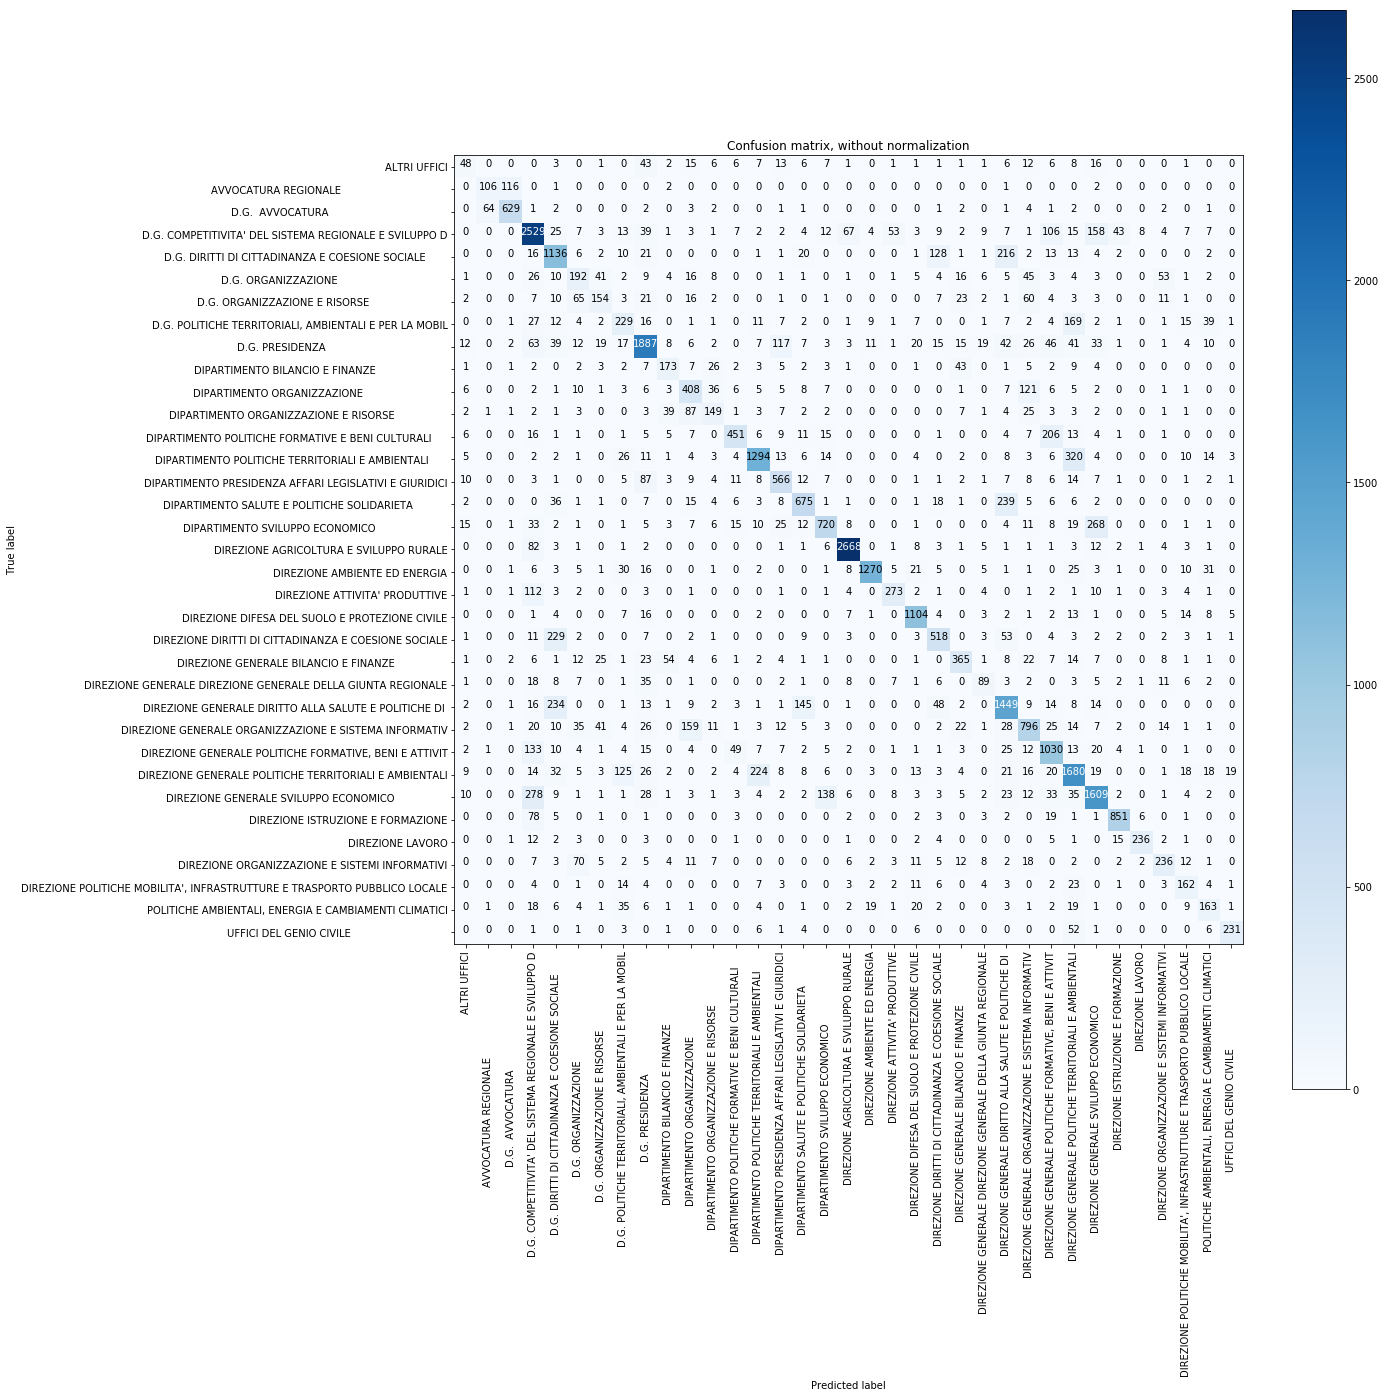

In [39]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')